regular trial

Status: Running on cpu
Starting training...
Epoch 5 | Avg Loss: 2.0755
Epoch 10 | Avg Loss: 2.0900
Epoch 15 | Avg Loss: 2.1299
Epoch 20 | Avg Loss: 2.1693
Epoch 25 | Avg Loss: 2.2052
Epoch 30 | Avg Loss: 2.2341


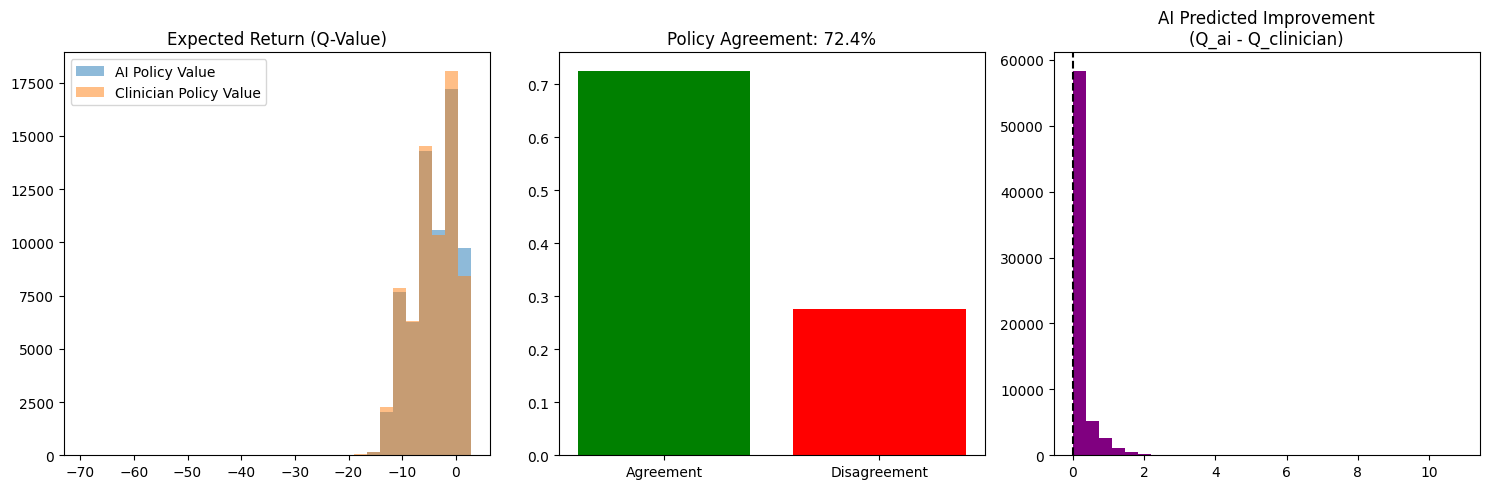

Evaluation Summary on 67967 Test Transitions:
Average Clinician Q-Value: -4.1625
Average AI Q-Value: -4.0192
AI Expected Gain: 0.1433


In [2]:
# =========================================================
# CELL 1: Setup and Imports
# =========================================================
import os, json, random, torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
from dataclasses import dataclass
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import joblib

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Status: Running on {DEVICE}")

# =========================================================
# CELL 2: Data Loading & Vectorized Preprocessing
# =========================================================
# load your data here. 
df = pd.read_csv("/Users/aryanb/aryan personal/code/datathon26/rl/data/data_v3_max_72_h.csv")

# Ensure numeric and sort
df["measure_time"] = pd.to_numeric(df["measure_time"], errors="coerce")
df = df.dropna(subset=["visit_occurrence_id", "measure_time"]).copy()
df = df.sort_values(["visit_occurrence_id", "measure_time"]).reset_index(drop=True)

# LOCF Features
VENT = ["peep_median", "peak_median"]
PHYS = ["map_median","sbp_median","dbp_median","temp_median",
        "wbc_median","hemoglobin_median","platelets_median",
        "sodium_median","potassium_median","chloride_median",
        "glucose_median","bun_median","creatinine_median","crp_median"]
VENT = [c for c in VENT if c in df.columns]
PHYS = [c for c in PHYS if c in df.columns]

for c in VENT + PHYS:
    df[f"{c}_missing"] = df[c].isna().astype(int)

df[PHYS] = df.groupby("visit_occurrence_id")[PHYS].ffill()
df[VENT] = df.groupby("visit_occurrence_id")[VENT].ffill()

# RL Feature Engineering
df["dp_dyn"] = df["peak_median"] - df["peep_median"]
df["peep_t"] = df["peep_median"]
df["delta_peep"] = df.groupby("visit_occurrence_id")["peep_t"].diff().fillna(0.0).round(2)

# Targets for Reward
df["dp_dyn_next"] = df.groupby("visit_occurrence_id")["dp_dyn"].shift(-1)
if "map_median" in df.columns:
    df["map_next"] = df.groupby("visit_occurrence_id")["map_median"].shift(-1)
else:
    df["map_next"] = np.nan

# Filter to valid transitions
rl = df[df["peep_t"].notna() & df["dp_dyn_next"].notna()].copy()
rl = rl[rl["delta_peep"].between(-5.0, 5.0)].copy()
rl["done"] = (rl["visit_occurrence_id"].shift(-1) != rl["visit_occurrence_id"]).astype(int)

# =========================================================
# CELL 3: Discrete Action Space & Vectorized Reward
# =========================================================
ACTION_VALUES = np.array([-3.0, -2.0, -1.0, -0.5, -0.25, -0.15, -0.10, -0.05, 0.0, 
                          0.05, 0.10, 0.15, 0.25, 0.5, 1.0, 2.0, 3.0], dtype=np.float32)
N_ACTIONS = len(ACTION_VALUES)

# Nearest bin mapping
rl["a"] = np.argmin(np.abs(rl["delta_peep"].values[:, None] - ACTION_VALUES), axis=1)

def compute_rewards_vectorized(df_rl):
    dpn = np.clip(df_rl["dp_dyn_next"].values, 0.0, 60.0)
    target = 15.0
    r = -np.abs(dpn - target) / 10.0 # Normalized DP penalty
    
    if "map_next" in df_rl.columns:
        mapn = df_rl["map_next"].values
        r -= np.where((~np.isnan(mapn)) & (mapn < 65.0), 1.0, 0.0) # Hypotension penalty
        r += np.where((~np.isnan(mapn)) & (dpn <= target) & (mapn >= 65.0), 0.2, 0.0) # Bonus
    
    r -= 0.02 * np.abs(df_rl["delta_peep"].values) # Moving penalty
    return r.astype(np.float32)

rl["r"] = compute_rewards_vectorized(rl)

# =========================================================
# CELL 4: Train/Test Split & Leakage-Free Scaling
# =========================================================
candidate_obs = ["fio2_median", "peep_t", "peak_median", "dp_dyn", "map_median"] 
candidate_obs += [c for c in rl.columns if c.endswith("_missing")]
obs_cols = [c for c in candidate_obs if c in rl.columns]

S_raw = rl[obs_cols].apply(pd.to_numeric, errors="coerce")
S2_raw = rl.groupby("visit_occurrence_id")[obs_cols].shift(-1).apply(pd.to_numeric, errors="coerce")
S2_raw = S2_raw.fillna(S_raw)

gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=SEED)
train_idx, test_idx = next(gss.split(rl, groups=rl["visit_occurrence_id"]))

# Prevent data leakage: Impute/Scale using TRAIN stats only
train_medians = S_raw.iloc[train_idx].median()
S_imputed = S_raw.fillna(train_medians)
S2_imputed = S2_raw.fillna(train_medians)

scaler = StandardScaler()
S_train = scaler.fit_transform(S_imputed.iloc[train_idx])
S2_train = scaler.transform(S2_imputed.iloc[train_idx])
S_test = scaler.transform(S_imputed.iloc[test_idx])
S2_test = scaler.transform(S2_imputed.iloc[test_idx])

A = rl["a"].values
R = rl["r"].values
D = rl["done"].values

# =========================================================
# CELL 5: Model Definitions & Weighted Sampling
# =========================================================
class QNet(nn.Module):
    def __init__(self, obs_dim, n_actions):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, 256), nn.ReLU(),
            nn.Linear(256, 256), nn.ReLU(),
            nn.Linear(256, n_actions)
        )
    def forward(self, x): return self.net(x)

# Handle action imbalance (clinicians often take Action 0)
a_train_t = torch.tensor(A[train_idx], dtype=torch.long)
counts = torch.bincount(a_train_t, minlength=N_ACTIONS).float()
weights = 1.0 / (torch.sqrt(counts) + 1.0)
sample_weights = weights[a_train_t]
sampler = torch.utils.data.WeightedRandomSampler(sample_weights, len(sample_weights))

train_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(
        torch.tensor(S_train, dtype=torch.float32),
        a_train_t,
        torch.tensor(R[train_idx], dtype=torch.float32),
        torch.tensor(S2_train, dtype=torch.float32),
        torch.tensor(D[train_idx], dtype=torch.float32)
    ), batch_size=2048, sampler=sampler
)

q = QNet(len(obs_cols), N_ACTIONS).to(DEVICE)
q_tgt = QNet(len(obs_cols), N_ACTIONS).to(DEVICE)
q_tgt.load_state_dict(q.state_dict())
opt = torch.optim.Adam(q.parameters(), lr=3e-4)

# =========================================================
# CELL 6: Training with CQL (Conservative Q-Learning)
# =========================================================
print("Starting training...")
for epoch in range(1, 31):
    q.train()
    total_loss = 0
    for s, a, r, s2, d in train_loader:
        s, a, r, s2, d = s.to(DEVICE), a.to(DEVICE), r.to(DEVICE), s2.to(DEVICE), d.to(DEVICE)
        
        with torch.no_grad():
            next_q = q_tgt(s2).max(1)[0]
            # Bellman Equation: y = r + gamma * (1-d) * max Q(s', a')
            y = r + 0.99 * (1.0 - d) * next_q
            
        q_all = q(s)
        q_sa = q_all.gather(1, a.view(-1, 1)).squeeze(1)
        
        td_loss = F.smooth_l1_loss(q_sa, y)
        # CQL penalty: penalize Q-values that are not in the dataset to prevent overestimation
        cql_loss = (torch.logsumexp(q_all, dim=1) - q_sa).mean()
        
        loss = td_loss + 1.0 * cql_loss
        
        opt.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(q.parameters(), 5.0)
        opt.step()
        total_loss += loss.item()
    
    if epoch % 5 == 0:
        q_tgt.load_state_dict(q.state_dict())
        print(f"Epoch {epoch} | Avg Loss: {total_loss/len(train_loader):.4f}")

# =========================================================
# CELL 7: Clinician vs. AI Evaluation (OPE)
# =========================================================
q.eval()
with torch.no_grad():
    S_test_t = torch.tensor(S_test, dtype=torch.float32).to(DEVICE)
    q_values = q(S_test_t).cpu().numpy()

# 1. AI Recommended Action vs. Clinician Action
ai_actions_idx = np.argmax(q_values, axis=1)
clinician_actions_idx = A[test_idx]

# 2. Predicted Values (Expected Return)
# How much "better" the AI thinks its action is compared to what the doctor did
v_ai = np.max(q_values, axis=1)
v_clinician = q_values[np.arange(len(q_values)), clinician_actions_idx]

# Visualizations
plt.figure(figsize=(15, 5))

# Plot 1: Value Distribution
plt.subplot(1, 3, 1)
plt.hist(v_ai, bins=30, alpha=0.5, label='AI Policy Value')
plt.hist(v_clinician, bins=30, alpha=0.5, label='Clinician Policy Value')
plt.title("Expected Return (Q-Value)")
plt.legend()

# Plot 2: Action Agreement
plt.subplot(1, 3, 2)
agreement = (ai_actions_idx == clinician_actions_idx).mean()
plt.bar(['Agreement', 'Disagreement'], [agreement, 1-agreement], color=['green', 'red'])
plt.title(f"Policy Agreement: {agreement:.1%}")

# Plot 3: Expected Improvement
plt.subplot(1, 3, 3)
improvement = v_ai - v_clinician
plt.hist(improvement, bins=30, color='purple')
plt.axvline(0, color='black', linestyle='--')
plt.title("AI Predicted Improvement\n(Q_ai - Q_clinician)")

plt.tight_layout()
plt.show()

# Print Case Study Summary
print(f"Evaluation Summary on {len(test_idx)} Test Transitions:")
print(f"Average Clinician Q-Value: {v_clinician.mean():.4f}")
print(f"Average AI Q-Value: {v_ai.mean():.4f}")
print(f"AI Expected Gain: {v_ai.mean() - v_clinician.mean():.4f}")

new trial

In [ ]:
import pandas as pd
import numpy as np
import os, json, random, torch
import torch.nn as nn
import torch.nn.functional as F
from dataclasses import dataclass
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import joblib

# =========================================================
# 1. Setup & Data Preparation
# =========================================================
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# --- Assuming 'df' is your pre-loaded dataframe ---
df["measure_time"] = pd.to_numeric(df["measure_time"], errors="coerce")
df = df.dropna(subset=["visit_occurrence_id", "measure_time"]).copy()
df = df.sort_values(["visit_occurrence_id", "measure_time"]).reset_index(drop=True)

# Carry-Forward Imputation
VENT = ["peep_median", "peak_median"]
PHYS = ["map_median","sbp_median","dbp_median","temp_median",
        "wbc_median","hemoglobin_median","platelets_median",
        "sodium_median","potassium_median","chloride_median",
        "glucose_median","bun_median","creatinine_median","crp_median"]
VENT = [c for c in VENT if c in df.columns]
PHYS = [c for c in PHYS if c in df.columns]

for c in VENT + PHYS:
    df[f"{c}_missing"] = df[c].isna().astype(int)

df[PHYS] = df.groupby("visit_occurrence_id")[PHYS].ffill()
df[VENT] = df.groupby("visit_occurrence_id")[VENT].ffill()

# Transitions & Actions
df["dp_dyn"] = df["peak_median"] - df["peep_median"]
df["peep_t"] = df["peep_median"]
df["delta_peep"] = df.groupby("visit_occurrence_id")["peep_t"].diff().fillna(0.0).round(2)
df["dp_dyn_next"] = df.groupby("visit_occurrence_id")["dp_dyn"].shift(-1)
df["map_next"] = df.groupby("visit_occurrence_id")["map_median"].shift(-1) if "map_median" in df.columns else np.nan

# Filter to valid rows
rl = df[df["peep_t"].notna() & df["dp_dyn_next"].notna()].copy()
rl = rl[rl["delta_peep"].between(-5.0, 5.0)].copy()
rl["done"] = (rl["visit_occurrence_id"].shift(-1) != rl["visit_occurrence_id"]).astype(int)

# =========================================================
# 2. Reward & Discrete Action Space
# =========================================================
ACTION_VALUES = np.array([-3.0, -2.0, -1.0, -0.5, -0.25, -0.15, -0.10, -0.05, 0.0, 
                          0.05, 0.10, 0.15, 0.25, 0.5, 1.0, 2.0, 3.0], dtype=np.float32)
N_ACTIONS = len(ACTION_VALUES)
rl["a"] = np.argmin(np.abs(rl["delta_peep"].values[:, None] - ACTION_VALUES), axis=1)

def compute_rewards_vectorized(df_rl):
    dpn = np.clip(df_rl["dp_dyn_next"].values, 0.0, 60.0)
    target = 15.0
    r = -np.abs(dpn - target) / 5.0  # Increased sensitivity from 10.0 to 5.0
    if "map_next" in df_rl.columns:
        mapn = df_rl["map_next"].values
        r -= np.where((~np.isnan(mapn)) & (mapn < 65.0), 1.5, 0.0)
        r += np.where((~np.isnan(mapn)) & (dpn <= target) & (mapn >= 65.0), 0.3, 0.0)
    r -= 0.05 * np.abs(df_rl["delta_peep"].values)
    return r.astype(np.float32)

rl["r"] = compute_rewards_vectorized(rl)

# =========================================================
# 3. Features & Splitting
# =========================================================
obs_cols = ["fio2_median", "peep_t", "peak_median", "dp_dyn", "map_median"] 
obs_cols += [c for c in rl.columns if c.endswith("_missing")]
obs_cols = [c for c in obs_cols if c in rl.columns]

S_raw = rl[obs_cols].apply(pd.to_numeric, errors="coerce")
S2_raw = rl.groupby("visit_occurrence_id")[obs_cols].shift(-1).apply(pd.to_numeric, errors="coerce").fillna(S_raw)

gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(rl, groups=rl["visit_occurrence_id"]))

scaler = StandardScaler()
S_train = scaler.fit_transform(S_raw.iloc[train_idx].fillna(S_raw.iloc[train_idx].median()))
S_test = scaler.transform(S_raw.iloc[test_idx].fillna(S_raw.iloc[train_idx].median()))
S2_train = scaler.transform(S2_raw.iloc[train_idx].fillna(S_raw.iloc[train_idx].median()))
S2_test = scaler.transform(S2_raw.iloc[test_idx].fillna(S_raw.iloc[train_idx].median()))

A, R, D = rl["a"].values, rl["r"].values, rl["done"].values

# =========================================================
# 4. Advanced Dueling Q-Network
# =========================================================
class DuelingQNet(nn.Module):
    def __init__(self, obs_dim, n_actions):
        super().__init__()
        self.feature_layer = nn.Sequential(nn.Linear(obs_dim, 256), nn.ReLU())
        
        # State Value stream (V)
        self.value_stream = nn.Sequential(nn.Linear(256, 128), nn.ReLU(), nn.Linear(128, 1))
        
        # Action Advantage stream (A)
        self.advantage_stream = nn.Sequential(nn.Linear(256, 128), nn.ReLU(), nn.Linear(128, n_actions))

    def forward(self, x):
        features = self.feature_layer(x)
        values = self.value_stream(features)
        advantages = self.advantage_stream(features)
        # Combine: Q(s,a) = V(s) + (A(s,a) - mean(A(s,a')))
        return values + (advantages - advantages.mean(dim=1, keepdim=True))

# Setup Training
q = DuelingQNet(len(obs_cols), N_ACTIONS).to(DEVICE)
q_tgt = DuelingQNet(len(obs_cols), N_ACTIONS).to(DEVICE)
q_tgt.load_state_dict(q.state_dict())
opt = torch.optim.Adam(q.parameters(), lr=1e-4) # Slightly lower learning rate for stability

# Weighted Sampler
a_train_t = torch.tensor(A[train_idx], dtype=torch.long)
counts = torch.bincount(a_train_t, minlength=N_ACTIONS).float()
weights = 1.0 / (torch.sqrt(counts) + 1.0)
sampler = torch.utils.data.WeightedRandomSampler(weights[a_train_t], len(train_idx))

train_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(
        torch.tensor(S_train, dtype=torch.float32), a_train_t,
        torch.tensor(R[train_idx], dtype=torch.float32),
        torch.tensor(S2_train, dtype=torch.float32),
        torch.tensor(D[train_idx], dtype=torch.float32)
    ), batch_size=2048, sampler=sampler
)

# =========================================================
# 5. Training Loop (CQL + Double DQN)
# =========================================================
for epoch in range(1, 41):
    q.train()
    for s, a, r, s2, d in train_loader:
        s, a, r, s2, d = s.to(DEVICE), a.to(DEVICE), r.to(DEVICE), s2.to(DEVICE), d.to(DEVICE)
        
        with torch.no_grad():
            # Double DQN: Use online net to pick action, target net to value it
            next_a = q(s2).argmax(1, keepdim=True)
            next_q = q_tgt(s2).gather(1, next_a).squeeze(1)
            y = r + 0.99 * (1.0 - d) * next_q
            
        q_all = q(s)
        q_sa = q_all.gather(1, a.view(-1, 1)).squeeze(1)
        
        td_loss = F.smooth_l1_loss(q_sa, y)
        cql_loss = (torch.logsumexp(q_all, dim=1) - q_sa).mean()
        
        loss = td_loss + 1.0 * cql_loss
        opt.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(q.parameters(), 5.0)
        opt.step()
    
    if epoch % 5 == 0:
        q_tgt.load_state_dict(q.state_dict())
        print(f"Epoch {epoch} | Avg Loss: {total_loss/len(train_loader):.4f}"))

# =========================================================
# 6. Evaluation
# =========================================================
q.eval()
with torch.no_grad():
    S_test_t = torch.tensor(S_test, dtype=torch.float32).to(DEVICE)
    q_vals = q(S_test_t).cpu().numpy()

v_ai = np.max(q_vals, axis=1)
v_clinician = q_vals[np.arange(len(q_vals)), A[test_idx]]

print("\n--- NEW RESULTS ---")
print(f"Transitions: {len(test_idx)}")
print(f"Avg Clinician Q: {v_clinician.mean():.4f}")
print(f"Avg AI Q: {v_ai.mean():.4f}")
print(f"Expected Gain: {v_ai.mean() - v_clinician.mean():.4f}")

# Visualize Action Differences
plt.figure(figsize=(10, 5))
plt.hist(ACTION_VALUES[np.argmax(q_vals, axis=1)], bins=ACTION_VALUES, alpha=0.5, label='AI Policy')
plt.hist(ACTION_VALUES[A[test_idx]], bins=ACTION_VALUES, alpha=0.5, label='Clinician')
plt.title("Action Distribution (ΔPEEP)")
plt.legend()
plt.show()

Epoch 5 complete
Epoch 10 complete
Epoch 15 complete
Epoch 20 complete
Epoch 25 complete
Epoch 30 complete
